In [1]:
%matplotlib inline
import numpy as np
from math import sqrt
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

RANDOM_SEED = 20090425

## 2. Dataset: Nashville Precipitation

In [2]:
precip = pd.read_table("nashville_precip.txt", index_col=0, na_values='NA', delim_whitespace=True)
precip.head();

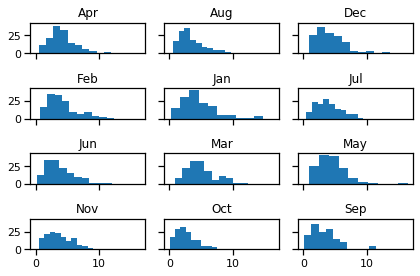

In [3]:
_ = precip.hist(sharex=True, sharey=True, grid=False)
plt.tight_layout()

## 3. Data Cleansing 
Since there is some missing data


In [4]:
precip.fillna(value={'Oct': precip.Oct.mean()}, inplace=True)
precip.head();

## 4. Exploration

Calculating the **means** and **variances** of precipitation, month by month:

In [5]:
precip_mean = precip.mean()
precip_mean

Jan    4.523688
Feb    4.097801
Mar    4.977589
Apr    4.204468
May    4.325674
Jun    3.873475
Jul    3.895461
Aug    3.367305
Sep    3.377660
Oct    2.610500
Nov    3.685887
Dec    4.176241
dtype: float64

In [6]:
precip_var = precip.var()
precip_var

Jan    6.928862
Feb    5.516660
Mar    5.365444
Apr    4.117096
May    5.306409
Jun    5.033206
Jul    3.777012
Aug    3.779876
Sep    4.940099
Oct    2.741659
Nov    3.679274
Dec    5.418022
dtype: float64

In [7]:
precip.Apr

Year
1871     4.13
1872     5.91
1873     3.59
1874    11.84
1875     4.22
        ...  
2007     2.75
2008     7.20
2009     4.13
2010     3.48
2011     7.51
Name: Apr, Length: 141, dtype: float64

# Finding Gamma Parameters $\alpha$ and $\beta$ 

Taking numbers, and modeling them as distributions, so that we can take a probabilistic program to figure out the best values for these parameters. 
First Trying it first for April Month Only.

C:\Users\User\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\hist.py:309: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


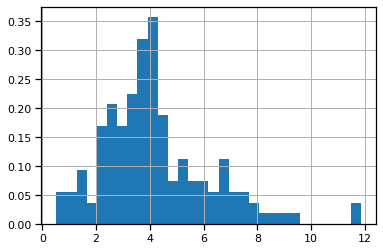

In [8]:
precip.Apr.hist(normed=True, bins=30)

# Finding $\alpha$ and $\beta$ using Uniform Distribution.

In [9]:
from pymc3 import Model, Uniform , Gamma

with Model() as rainfall_model:
    ualpha = Uniform('ualpha', lower=0, upper=15)
    ubeta = Uniform('ubeta', lower=0, upper=15)

with rainfall_model:
    april_like = Gamma('april_like', alpha=ualpha, beta=ubeta, observed=precip.Apr)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\User\anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [10]:
from pymc3 import fit

with rainfall_model: 
    rainfall_trace = fit(random_seed=RANDOM_SEED).sample(1000)
    

Finished [100%]: Average Loss = 368


C:\Users\User\anaconda3\lib\site-packages\pymc3\plots\__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
C:\Users\User\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


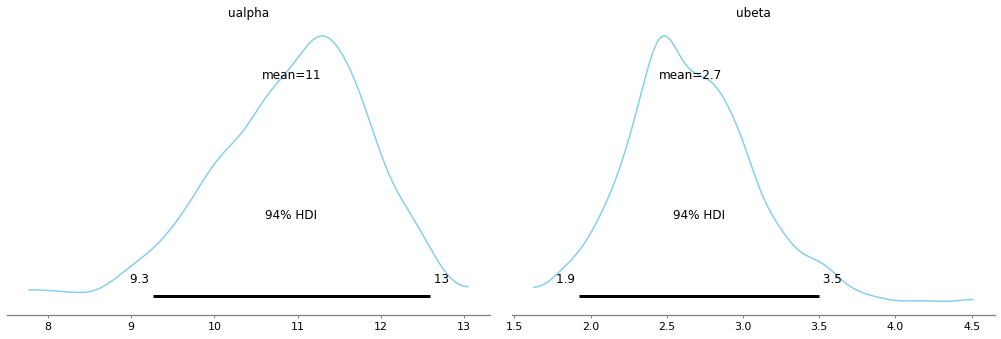

In [11]:
from pymc3 import plot_posterior

plot_posterior(rainfall_trace[100:], 
                varnames=['ualpha', 'ubeta'],
                color='#87ceeb');


## Trying To Fit The Data using the $\alpha$ and $\beta$ values

C:\Users\User\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\hist.py:309: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


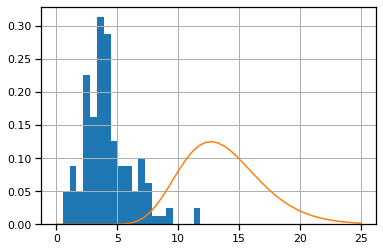

In [12]:
from scipy.stats.distributions import gamma

ualpha_posterior_mean = 11
ubeta_posterior_mean = 2.7

precip.Apr.hist(normed=True, bins=20)
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 25), ualpha_posterior_mean, ubeta_posterior_mean))

# Finding $\alpha$ and $\beta$ using Normal Distribution.

In [13]:
from pymc3 import Model, Uniform , Normal , Exponential

precip_mean_apr = precip_mean.Apr
precip_var_apr = sqrt(precip_var.Apr)

with Model() as rainfall_model:
    ualpha = Normal('ualpha', mu=precip_mean_apr, sigma=precip_var_apr)
    ubeta = Normal('ubeta', mu=precip_mean_apr, sigma=precip_var_apr)

with rainfall_model:
    april_like = Gamma('april_like', alpha=ualpha, beta=ubeta, observed=precip.Apr)

C:\Users\User\anaconda3\lib\site-packages\pymc3\distributions\continuous.py:103: UserWarning: The variable specified for alpha has negative support for Gamma, likely making it unsuitable for this parameter.
  warnings.warn(msg)
C:\Users\User\anaconda3\lib\site-packages\pymc3\distributions\continuous.py:103: UserWarning: The variable specified for beta has negative support for Gamma, likely making it unsuitable for this parameter.
  warnings.warn(msg)


In [14]:
from pymc3 import fit

with rainfall_model: 
    rainfall_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 329.21


C:\Users\User\anaconda3\lib\site-packages\pymc3\plots\__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
C:\Users\User\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


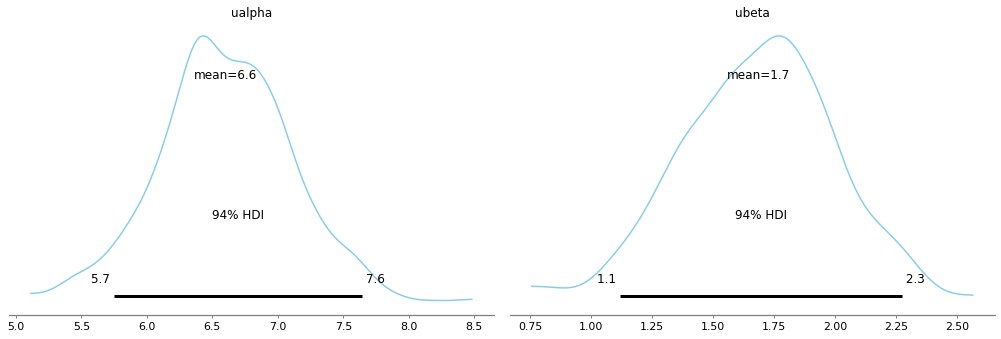

In [15]:
from pymc3 import plot_posterior

plot_posterior(rainfall_trace[100:], 
                varnames=['ualpha', 'ubeta'],
                color='#87ceeb');

## Trying To Fit The Data using the $\alpha$ and $\beta$ values

C:\Users\User\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\hist.py:309: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


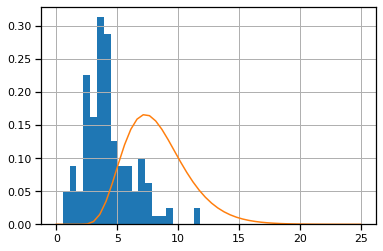

In [18]:
from scipy.stats.distributions import gamma

ualpha_posterior_mean = 6.6
ubeta_posterior_mean = 1.7

precip.Apr.hist(normed=True, bins=20)
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 25), ualpha_posterior_mean, ubeta_posterior_mean))

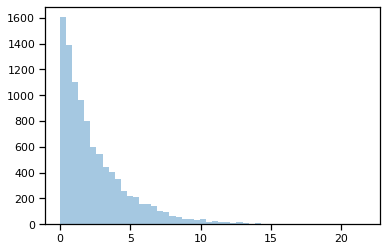

In [19]:
sns.distplot(Exponential.dist(2/5).random(size=10000), kde=False);

In [20]:
from pymc3 import Model, Uniform , Normal , Exponential

with Model() as rainfall_model:
    ualpha = Exponential('ualpha', 2/5 )
    ubeta = Exponential('ubeta',2/5)

with rainfall_model:
    april_like = Gamma('april_like', alpha=ualpha, beta=ubeta, observed=precip.Apr)

In [21]:
from pymc3 import fit

with rainfall_model: 
    rainfall_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 316.42


C:\Users\User\anaconda3\lib\site-packages\pymc3\plots\__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
C:\Users\User\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


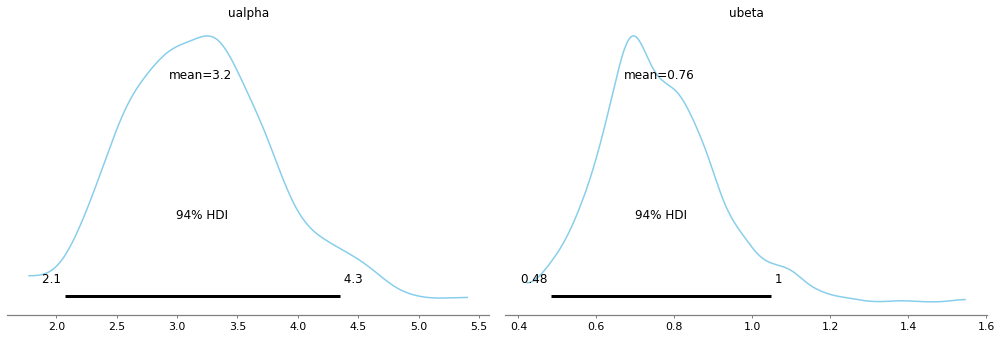

In [22]:
from pymc3 import plot_posterior

plot_posterior(rainfall_trace[100:], 
                varnames=['ualpha', 'ubeta'],
                color='#87ceeb');

## Trying To Fit The Data using the alpha and beta values

C:\Users\User\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\hist.py:309: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


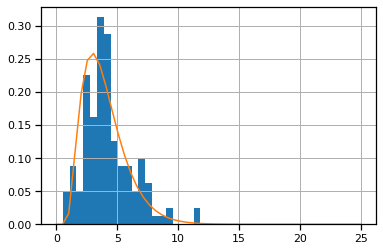

In [23]:
from scipy.stats.distributions import gamma

ualpha_posterior_mean = 3.2
ubeta_posterior_mean = 0.76

precip.Apr.hist(normed=True, bins=20)
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 25), ualpha_posterior_mean, ubeta_posterior_mean))

In [24]:
from pymc3 import Model, Uniform , Normal , Exponential

with Model() as rainfall_model:
    ualpha_all = Exponential('ualpha_all', 2/5 )
    ubeta_all = Exponential('ubeta_all',2/5)


with rainfall_model:
    jan_like = Gamma('all_months', alpha=ualpha_all, beta=ubeta_all, observed=precip)

In [25]:
from pymc3 import fit

with rainfall_model: 
    rainfall_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 3,817.7


C:\Users\User\anaconda3\lib\site-packages\pymc3\plots\__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
C:\Users\User\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


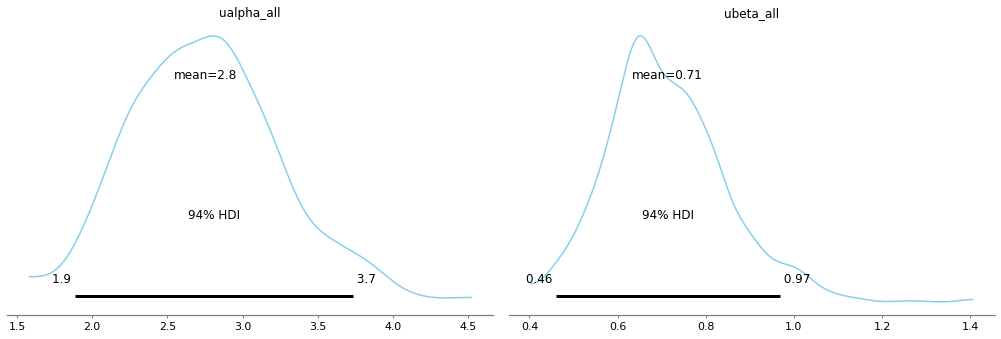

In [26]:
from pymc3 import plot_posterior

plot_posterior(rainfall_trace[100:], 
                varnames=['ualpha_all', 'ubeta_all'],
                color='#87ceeb');

C:\Users\User\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\hist.py:404: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(data[col].dropna().values, bins=bins, **kwds)


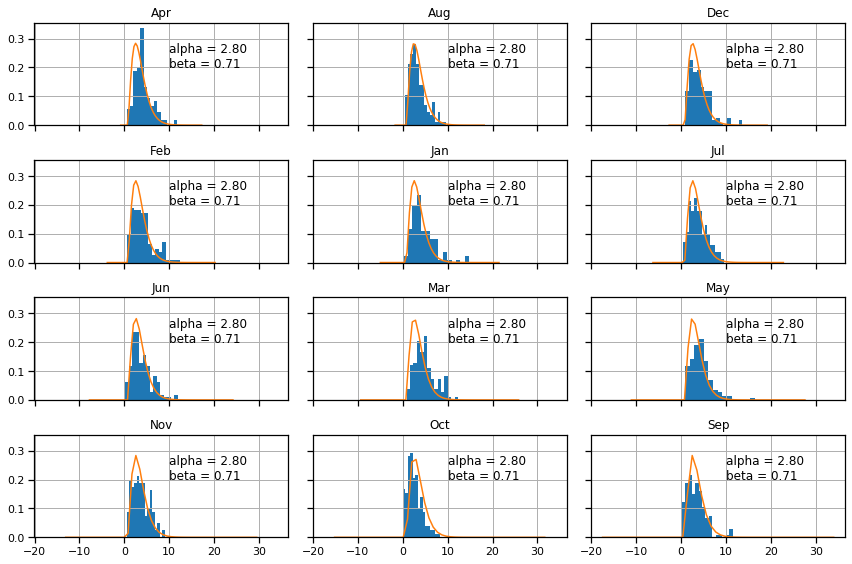

In [27]:
axs = precip.hist(normed=True, figsize=(12, 8), sharex=True, sharey=True, bins=15, grid=True)

for ax in axs.ravel():

    # Get month
    m = ax.get_title()

    # Plot fitted distribution
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, gamma.pdf(x,2.8, 0.71))

    # Annotate with parameter estimates
    label = 'alpha = {0:.2f}\nbeta = {1:.2f}'.format(2.8,0.71)
    ax.annotate(label, xy=(10, 0.2))

plt.tight_layout()